In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import wandb
import tempfile
import os
from models.normalizing_flow import HierarchicalNormalizingFlowSB
import numpy as np
import torch
import matplotlib.pyplot as plt
from torch import nn


In [3]:
from train_flow_sb import unflatten, object_from_config

In [4]:
api = wandb.Api()

In [5]:
# run = api.run('druhe/gw-src/ntnb1v04')
run = api.run('druhe/gw-src/1l9zbsnf')



In [6]:
config = unflatten(run.config)

In [7]:
config['model']['sb_weight']
config['model']['prior_weight']

1

In [8]:
dataset = object_from_config(config, key='dataset')
dataset = dataset(**config['dataset'])

In [9]:
flows = object_from_config(config, key='flow')(**config['flow'])

In [10]:
tempdir = tempfile.TemporaryDirectory()

In [11]:
checkpoints = [f for f in run.files() if f.name.endswith('.pt')]

ckpt = checkpoints[-1]

ckpt_path = ckpt.download(root=tempdir.name, replace=True)

ckpt_path

<_io.TextIOWrapper name='/tmp/tmpcpw8rwzm/epoch_500_step_513525_val_loss=8.3308.pt' mode='r' encoding='UTF-8'>

In [12]:
model = object_from_config(config, key='model')(flows=flows, dataset=dataset, prior_weight=1, sb_weight=0)

In [13]:
model.load_state_dict(torch.load(ckpt_path.name), strict=False)

model.eval()

HierarchicalNormalizingFlowSB(
  (trainable_flows): ModuleList(
    (0): Planar()
    (1): Planar()
    (2): Planar()
    (3): Planar()
    (4): Planar()
    (5): Planar()
    (6): Planar()
    (7): Planar()
    (8): Planar()
    (9): Planar()
  )
)

In [14]:
model.to('cuda')

HierarchicalNormalizingFlowSB(
  (trainable_flows): ModuleList(
    (0): Planar()
    (1): Planar()
    (2): Planar()
    (3): Planar()
    (4): Planar()
    (5): Planar()
    (6): Planar()
    (7): Planar()
    (8): Planar()
    (9): Planar()
  )
)

In [15]:
import hamiltorch

from torch.nn.utils import _stateless


In [16]:
def flatten_params(parameters):
    """
    flattens all parameters into a single column vector. Returns the dictionary to recover them
    :param: parameters: a generator or list of all the parameters
    :return: a dictionary: {"params": [#params, 1],
    "indices": [(start index, end index) for each param] **Note end index in uninclusive**

    """
    l = [torch.flatten(p) for p in parameters]
    indices = []
    s = 0
    for p in l:
        size = p.shape[0]
        indices.append((s, s+size))
        s += size
    flat = torch.cat(l).view(-1, 1)
    return flat, indices


def unflatten_params(flat_params, indices, model):
    """
    Gives a list of recovered parameters from their flattened form
    :param flat_params: [#params, 1]
    :param indices: a list detaling the start and end index of each param [(start, end) for param]
    :param model: the model that gives the params with correct shapes
    :return: the params, reshaped to the ones in the model, with the same order as those in the model
    """
    l = [flat_params[s:e] for (s, e) in indices]
    for i, p in enumerate(model.parameters()):
        l[i] = l[i].view(*p.shape)
    return tuple(nn.Parameter(p) for p in l)


In [17]:
params_flat, indices = flatten_params(model.parameters())
names = list(n for n, _ in model.named_parameters())


In [18]:
model = model.double()

params_init = hamiltorch.util.flatten(model).clone().double()


In [19]:
events = np.load('../../datasets/sampleDict_FAR_1_in_1_yr.pickle', allow_pickle=True)
sample_numbers = []
for event in events:
    sample_numbers.append(len(events[event]['m1']))

In [20]:
max(sample_numbers)

268806

In [21]:
min(sample_numbers)

3194

In [22]:
loader = dataset.val_dataloader()

In [23]:
iterable = iter(loader)

In [24]:
likelihoods = []
priors = []
total = []
i = 0
def log_prob(params, y=None):
    global iterable
    global likelihoods
    global priors
    global total
    global i 
    try:
        batch = next(iterable)
    except StopIteration:
        iterable = iter(loader)
        batch = next(iterable)
    
    gw_batch = batch[0].double().to(model.device)
    
    params = params.to(model.device)
    prior = torch.distributions.Normal(params_init.to(model.device), 0.01).log_prob(params)

    params = unflatten_params(params, indices, model)
    out: torch.Tensor = _stateless.functional_call(model, {n: p for n, p in zip(names, params)}, gw_batch)    
    ll = prior.sum() + out.mean()
    
    if i % 20 == 0:
        likelihoods.append(out.mean().item())
        priors.append(prior.sum().item())
        total.append(likelihoods[-1] + priors[-1])
    i += 1
    return ll




In [25]:

# N = int(1e4)
# burn = 512
# N_nuts = N + burn
# step_size = 2e-4
# L = 20

# samples = hamiltorch.sample(
#     log_prob, 
#     params_init=params_init, 
#     num_samples=N_nuts, 
#     num_steps_per_sample=L, 
#     step_size=step_size, 
#     burn=burn, 
# #     desired_accept_rate=0.8,
# #     sampler=hamiltorch.Sampler.HMC_NUTS,
#     debug=False)

In [26]:
# samples = torch.stack(samples)



In [26]:
# torch.save(samples, 'mcmc_samples.pth')

In [27]:
samples = torch.load('mcmc_samples.pth')

In [29]:
axes_names = []
axes = []

for n, ax in dataset.grid.items():
    axes_names.append(n)
    axes.append(ax)

d = dataset.dimensionality
m1, m2, z, chi = np.stack(np.meshgrid(*axes, indexing="ij")).reshape(d, -1)

resolutions = [len(ax) for ax in axes]

input = np.stack([m1, m2, z, chi], axis=-1)
input = torch.from_numpy(input)

In [226]:
input = input.to(model.device)

In [227]:
def functional_call(model, flat_params):
    
    params = unflatten_params(flat_params, indices, model)

    out: torch.Tensor = _stateless.functional_call(model, {n: p for n, p in zip(names, params)}, input)    
    return out

In [228]:
with torch.no_grad():
    logprob = functional_call(model, params_init.to(model.device))
prob = logprob.exp().view(*resolutions)


In [229]:
prob.max()

tensor(0.6721, device='cuda:0', dtype=torch.float64)

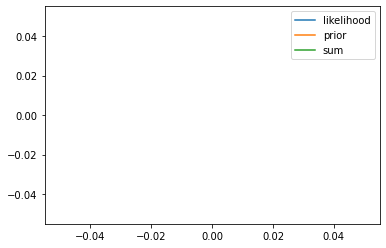

In [33]:
plt.plot(likelihoods, label='likelihood')
plt.plot(priors, label='prior')
plt.plot(total, label='sum')
plt.legend()

# plt.ylim(-20, -5)

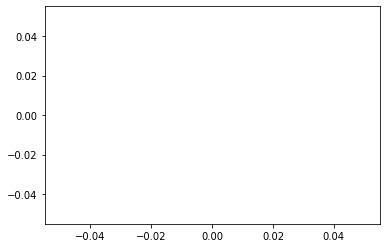

In [34]:
plt.plot(likelihoods)

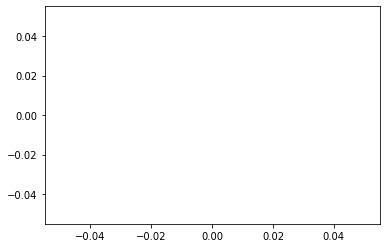

In [35]:
plt.plot(priors)


In [36]:
pm1m2 = prob.sum((2, 3)).cpu()

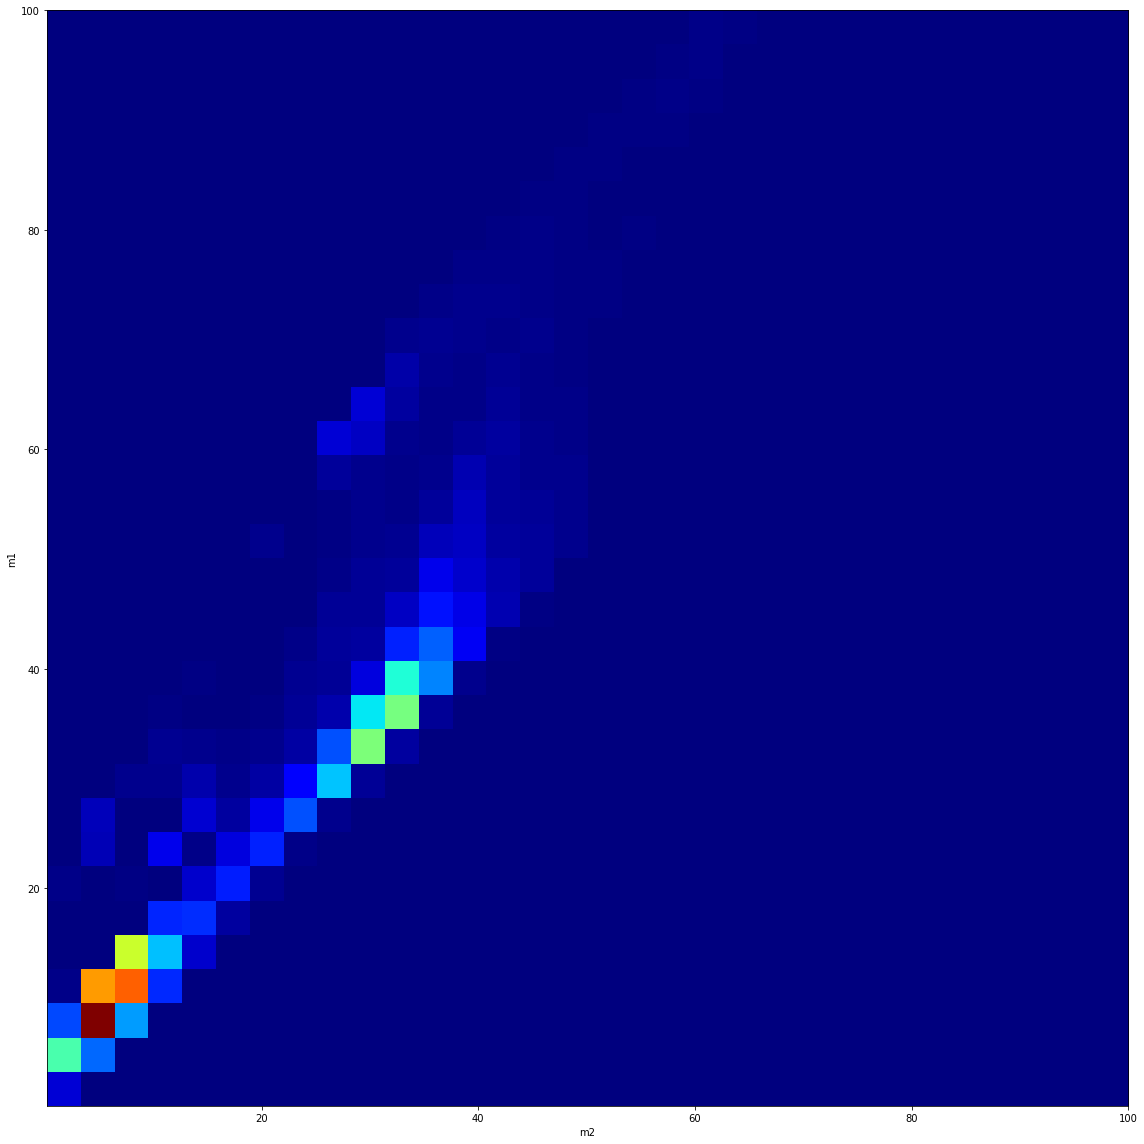

In [37]:
fig = plt.figure(figsize=(16, 16), facecolor="white")
plt.imshow(
    pm1m2,
    cmap="jet",
    origin="lower",
    extent=(
        axes[1][0],
        axes[1][-1],
        axes[0][0],
        axes[0][-1],
    ),  # origin='lower' changes the order
    aspect="auto",
)

plt.xlabel(axes_names[1])  # origin='lower' changes the order
plt.ylabel(axes_names[0])
plt.tight_layout()

In [38]:
pm1= prob.sum((1, 2, 3)).cpu()

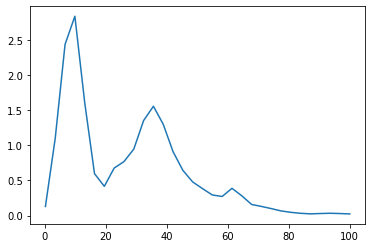

In [39]:
plt.plot(axes[0], pm1)
# plt.yscale('log')

In [40]:
from scipy.interpolate import interp1d

In [41]:
i = interp1d(axes[0], pm1, kind='cubic')

In [42]:
axes[0]

array([  0.2       ,   3.41935484,   6.63870968,   9.85806452,
        13.07741935,  16.29677419,  19.51612903,  22.73548387,
        25.95483871,  29.17419355,  32.39354839,  35.61290323,
        38.83225806,  42.0516129 ,  45.27096774,  48.49032258,
        51.70967742,  54.92903226,  58.1483871 ,  61.36774194,
        64.58709677,  67.80645161,  71.02580645,  74.24516129,
        77.46451613,  80.68387097,  83.90322581,  87.12258065,
        90.34193548,  93.56129032,  96.78064516, 100.        ])

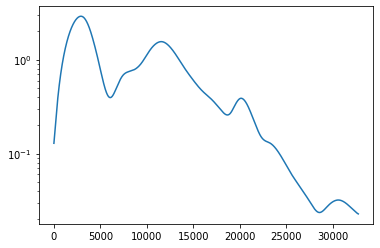

In [43]:
plt.plot(i(np.linspace(0.2, 100, 32768)))
plt.yscale('log')

In [44]:
import tqdm

In [45]:
samples = samples.cuda()

In [46]:
model = model.cuda()

In [47]:
input = input.cuda()

In [48]:
from numpy.lib.format import open_memmap

In [49]:
prob.shape

torch.Size([32, 32, 32, 32])

In [50]:
shape = [len(samples)] + list(prob.shape)

In [87]:
probs = open_memmap('probs.npy', mode='r', shape=tuple(shape), dtype=np.float32)

In [52]:
# for i, sample in enumerate(tqdm.tqdm(samples)):
#     with torch.no_grad():
#         logprob = functional_call(model, sample)
#     prob = logprob.exp().view(*resolutions).cpu().numpy()
#     probs[i] = prob

100%|█████████████████████████████████████| 10000/10000 [09:06<00:00, 18.29it/s]


In [88]:
probs = torch.from_numpy(probs)

/tmp/ipykernel_1352476/2126704153.py:1: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ../torch/csrc/utils/tensor_numpy.cpp:178.)
  probs = torch.from_numpy(probs)


In [89]:
m1 = probs.sum((2, 3, 4)).cpu().numpy()

In [90]:
m1_med = np.median(m1, axis=0)

In [91]:
m1_005 = np.percentile(m1, 5, axis=0)
m1_095 = np.percentile(m1, 95, axis=0)

(1e-05, 3)

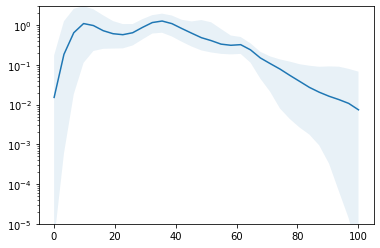

In [92]:
plt.plot(axes[0], m1_med)
plt.fill_between(axes[0], m1_005, m1_095, alpha=0.1)
plt.yscale('log')
plt.ylim((1e-5, 3))

In [94]:
# plt.plot(axes[0], pm1)
# plt.fill_between(axes[0], m1_005, m1_095, alpha=0.1)
# plt.yscale('log')
# plt.ylim((1e-5, 3))

In [203]:
import numpy as np

In [210]:
m1_ = m1.copy()
m1_[:, 0] *= 1e-4

In [211]:
m1__med = np.median(m1_, axis=0)
m1__005 = np.percentile(m1_, 5, axis=0)
m1__095 = np.percentile(m1_, 95, axis=0)


In [212]:
axis_upsampled = np.linspace(0.2, 100, 16384)

i = interp1d(axes[0], m1__med, kind='quadratic')
m1__med = i(axis_upsampled)


i = interp1d(axes[0], m1__005, kind='quadratic')
m1__005 = i(axis_upsampled)

i = interp1d(axes[0], m1__095, kind='quadratic')
m1__095 = i(axis_upsampled)


In [213]:
norm = m1__med.sum()

In [214]:
# m1__med = m1__med / norm
# m1__005 = m1__005 / norm
# m1__095 = m1__095 / norm

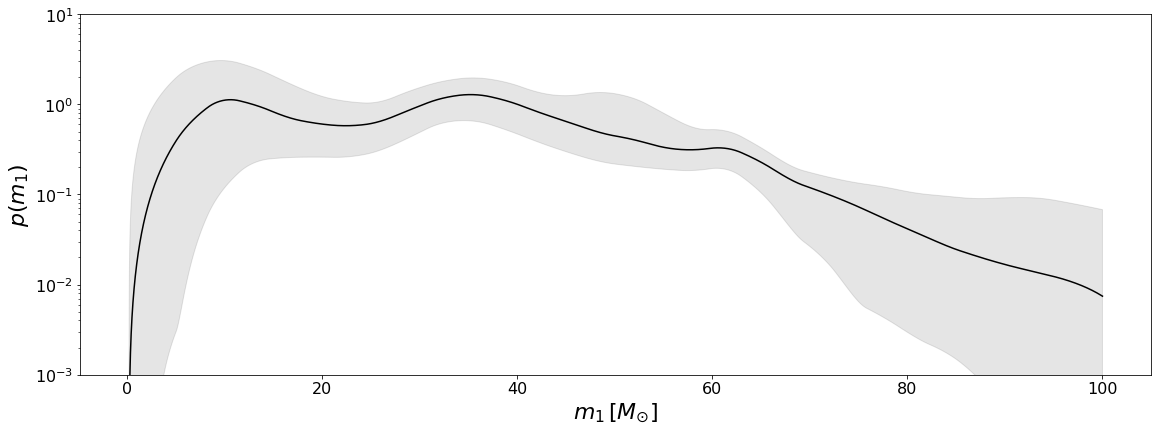

In [223]:

plt.figure(figsize=(16, 6), facecolor='white')
plt.plot(axis_upsampled, m1__med, c='black')
plt.fill_between(axis_upsampled, m1__005, m1__095, alpha=0.1, color='black')
plt.yscale('log')
plt.ylabel(r'$p(m_1)$', fontsize=22)
plt.xlabel(r'$m_1 \, [M_{\odot}]$', fontsize=22)
plt.ylim((1e-3, 10))
plt.tight_layout()
plt.yticks(fontsize=16)
plt.xticks(fontsize=16)
plt.savefig('pm1.pdf', bbox_inches='tight')